D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

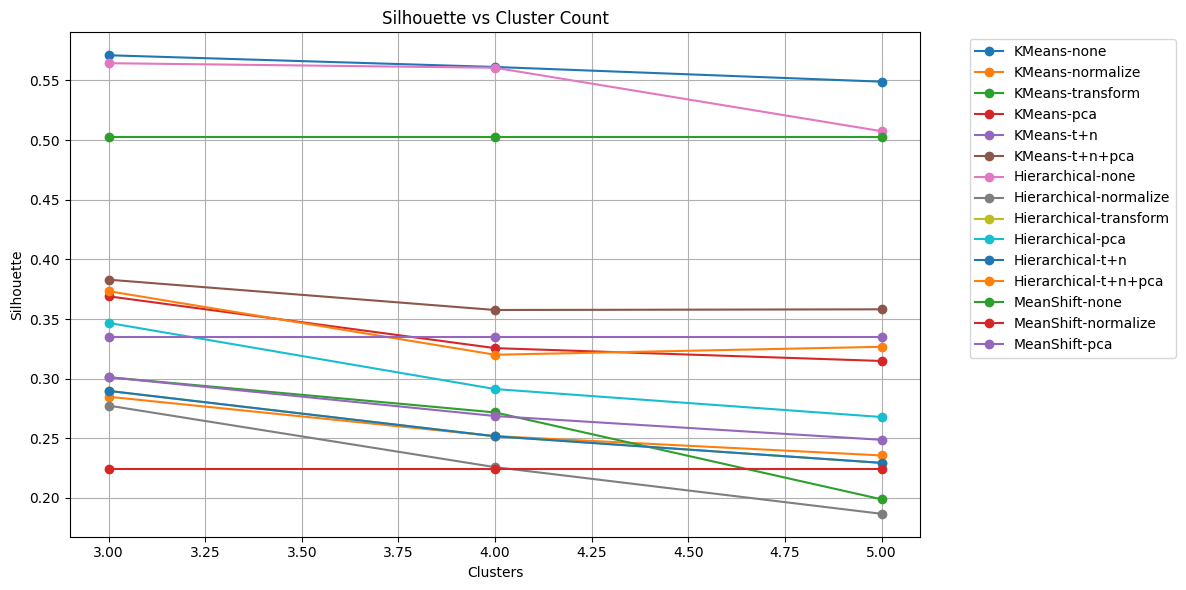

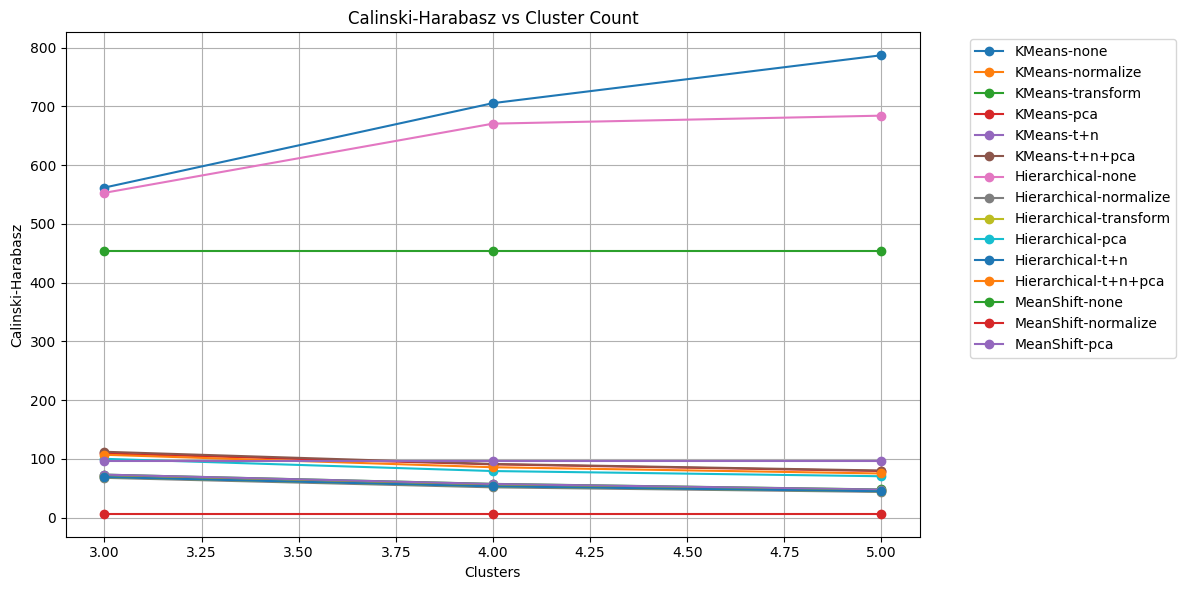

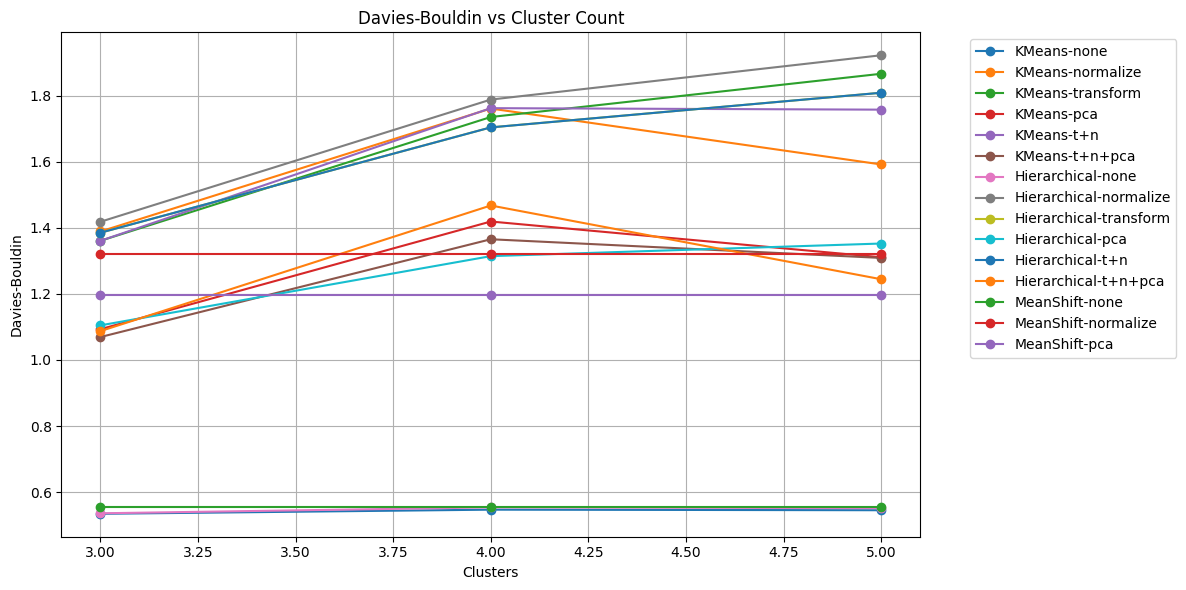

In [7]:
# 📌 Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid

# 📥 Load Dataset
df = pd.read_csv('wine_dataset.csv')
X = df.drop('target', axis=1)

# 📊 Define Preprocessing Techniques
def preprocess(X, method):
    if method == "none":
        return X
    elif method == "normalize":
        return StandardScaler().fit_transform(X)
    elif method == "transform":
        return PowerTransformer().fit_transform(X)
    elif method == "pca":
        return PCA(n_components=5).fit_transform(StandardScaler().fit_transform(X))
    elif method == "t+n":
        return StandardScaler().fit_transform(PowerTransformer().fit_transform(X))
    elif method == "t+n+pca":
        return PCA(n_components=5).fit_transform(StandardScaler().fit_transform(PowerTransformer().fit_transform(X)))

# 📌 Clustering Methods
clustering_algos = {
    "KMeans": lambda c: KMeans(n_clusters=c, n_init=10),
    "Hierarchical": lambda c: AgglomerativeClustering(n_clusters=c),
    "MeanShift": lambda _: MeanShift()
}

# 📌 Parameters
preprocessing_methods = ["none", "normalize", "transform", "pca", "t+n", "t+n+pca"]
clusters = [3, 4, 5]

# 📊 Results DataFrame
results = []

for method in preprocessing_methods:
    X_proc = preprocess(X, method)
    for algo_name, algo_fn in clustering_algos.items():
        for c in clusters:
            if algo_name == "MeanShift" and method in ["transform", "t+n", "t+n+pca"]:
                continue  # Skip unstable MS runs
            try:
                model = algo_fn(c)
                labels = model.fit_predict(X_proc)
                sil = silhouette_score(X_proc, labels)
                ch = calinski_harabasz_score(X_proc, labels)
                db = davies_bouldin_score(X_proc, labels)
                results.append([algo_name, method, c, sil, ch, db])
            except Exception as e:
                results.append([algo_name, method, c, None, None, None])

# 📋 Create DataFrame
results_df = pd.DataFrame(results, columns=["Algorithm", "Preprocessing", "Clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
results_df.sort_values(by=["Algorithm", "Preprocessing", "Clusters"]).reset_index(drop=True)

results_df.to_csv("clustering_results.csv", index=False)

# 📊 Plotting function
def plot_metrics(results_df, metric_name, filename):
    plt.figure(figsize=(12, 6))
    for algo in results_df["Algorithm"].unique():
        subset = results_df[results_df["Algorithm"] == algo]
        for method in subset["Preprocessing"].unique():
            method_subset = subset[subset["Preprocessing"] == method]
            plt.plot(
                method_subset["Clusters"],
                method_subset[metric_name],
                marker='o',
                label=f"{algo}-{method}"
            )
    plt.title(f"{metric_name} vs Cluster Count")
    plt.xlabel("Clusters")
    plt.ylabel(metric_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# 📈 Generate plots for each metric
plot_metrics(results_df, "Silhouette", "silhouette_score_plot.png")
plot_metrics(results_df, "Calinski-Harabasz", "calinski_harabasz_plot.png")
plot_metrics(results_df, "Davies-Bouldin", "davies_bouldin_plot.png")
